In [ ]:
#this is a cylinderical light sheet simulation
#import the necessary modules
%pylab inline
import os
import pyoptic2 as pyo
from pyoptic2.util import zemax, read_agf
from pyoptic2.display import plot2d, plot_system2d
import pandas as pd
from pyoptic2 import material

# get the current path
mysetup_dir = os.getcwd()
# define the .zar file name
zar_file_name1 = 'AC254_100_A_Zemax.zar'
zar_file_name2 = 'LJ1567L1_Zemax.zar'
# combine the directory and the file name
zar_file_path1 = os.path.join(mysetup_dir, zar_file_name1)
print(zar_file_path1)
zar_file_path2 = os.path.join(mysetup_dir, zar_file_name2)
print(zar_file_path2)
# read .zar file
AC254_100_A = zemax.read_cached_zar(zar_file_path1)
LJ1567L1= zemax.read_cached_zar(zar_file_path2)

# read mylens data
my_lens_data = pd.read_excel(os.path.join(mysetup_dir, 'MyCylindricalLens.xlsx'))
# # put the light source
# src = pyo.PointSource('light source', pyo.Placement([0,0,0], [0,1,0]), NA=0.12, color=(1,0,0), wavelength=642.)
# r = src.principle_ray

# #generate the system
# s = pyo.System()
# my_lens_data

Populating the interactive namespace from numpy and matplotlib
c:\localfiles\pyoptic2\mysetup\AC254_100_A_Zemax.zar
c:\localfiles\pyoptic2\mysetup\LJ1567L1_Zemax.zar


,Surface,r,d,Glass,nd,vd,notes,Surface_Type
0,1,inf,1.000000e+10,air,NaN,NaN,NaN,Plane
1,2,46.0,5.510000e+00,F_SILICA,NaN,NaN,NaN,Cylindrical
2,3,inf,9.536603e+01,air,NaN,NaN,NaN,Plane


In [3]:
# add materials
air = material.Material(material.Material.REFRACT, 1.0)


In [4]:
# add Glasses
glasses = zemax.readZar(zar_file_path2)[1] # Get F_SILICA glass from LJ1567L1_Zemax.zar
ohara = read_agf.read_glasscat(os.path.join(mysetup_dir, 'OHARA_180518.AGF')) # Read OHARA_180518.AGF to import more glasses
glasses.update(ohara['ohara_180518'])
# glasses['F_SILICA'] # Check F_SILICA glass

detected 12 sections


In [5]:
# build a dictionary of glasses
lens_glasses = {}
for s in my_lens_data.Glass:
    g_data = glasses.get(s, None)
    if not g_data is None:
        g = zemax.Glass(g_data)
        lens_glasses[s] = g
        
        
#add the RIs for air and our immersion
lens_glasses['air'] = air

print(lens_glasses.keys())

dict_keys(['F_SILICA', 'air'])


In [6]:
def _surface(Surface_Type, **kwargs):
    """ Helper function to choose a plane, cylindrical, or spherical surface as appropriate """
    if Surface_Type == 'Plane':
        return pyo.PlaneSurface(**kwargs)
    elif Surface_Type == 'Cylindrical':
        # 需要提供 curvature_radius 和 curvature_axis
        if 'curvature_radius' not in kwargs:
            kwargs['curvature_radius'] = kwargs.pop('radius', None)  # 从 radius 提取曲率半径
        if 'curvature_axis' not in kwargs:
            kwargs['curvature_axis'] = np.array([0, 1, 0])  # 默认沿 Y 轴弯曲
        return pyo.CylindricalSurface(**kwargs)
    else:
        return pyo.SphericalSurface(**kwargs)

    

In [7]:
def objective(d, pos, sph=2.5823, d2=7.95):
    """ Build an objective pointed in direction d, with a focus at pos (both numpy arrays) """
    z0 = 0

    params = {'d1' : 0,  
              'd2' : d2, 
              'd10': sph,  
              'd14' : 4.6 - sph  
              }

    surfaces = []
    for i in range(len(my_lens_data)):
        glass = lens_glasses.get(my_lens_data.Glass[i], None)
        if glass is None:
            nd = my_lens_data.nd[i]
            vd = my_lens_data.vd[i]
            if np.isnan(nd) or np.isnan(vd):
                raise ValueError(f"Invalid nd or vd for lens {i}: nd={nd}, vd={vd}")
            glass = material.AbbeGlass(material.Material.REFRACT, nd=nd, vd=vd)

        radius = my_lens_data.r[i]
        Surface_Type = my_lens_data.Surface_Type[i]

        surfaces.append(_surface(Surface_Type=my_lens_data.Surface_Type[i],
                         radius=radius,
                         curvature_radius=radius,  # 传递给 CylindricalSurface
                         name=f'Objective_{i+1}',
                         dimension=np.ones(3)*10.,
                         placement=pyo.Placement(z0*d + pos, d),
                         material=glass))


        dz = params.get(f'd{i}', None)
        if dz is None:
            dz = float(my_lens_data.d[i]) if not np.isnan(my_lens_data.d[i]) else 0

        z0 += dz

    return surfaces

In [8]:
#create an optical system and add the objective, tube lens, and two camera planes (one at and one after the nominal focus)
#the point here is just a sanity check - do we actually create something which looks like an objective

# start at the origin
pos = np.zeros(3)

# and point along the +ve x axis
d = np.zeros(3)
d[0] = 1.0

s = pyo.System()
s.extend(objective(d, pos, 2.5823))

# put a surface just before the focal point (we will propagate rays from here to the true focus later on when generating PSFs etc ...)
s.append(pyo.PlaneSurface(name='pre-focal plane', 
                          dimension=np.ones(3)*30., 
                          placement=pyo.Placement((207.6 + (166 + 80))*d + pos,d), 
                          material=air))

In [9]:
# check reading .zar files functions
# from pprint import pprint

# print("AC254_100_A:")
# pprint(AC254_100_A.__dict__)

# print("\nLJ1567L1:")
# pprint(LJ1567L1.__dict__)

In [10]:
# add lenses
# lens1, r = s.add(pyo.my_lens_data(r.prop(100), flip=True, f=100), r)
# cam, r = s.add(pyo.Mirror(r.prop(100), name='Camera'), r)

(-16018320684.480242,
 16018320684.480242,
 -999999986.5199997,
 20999999716.919994)

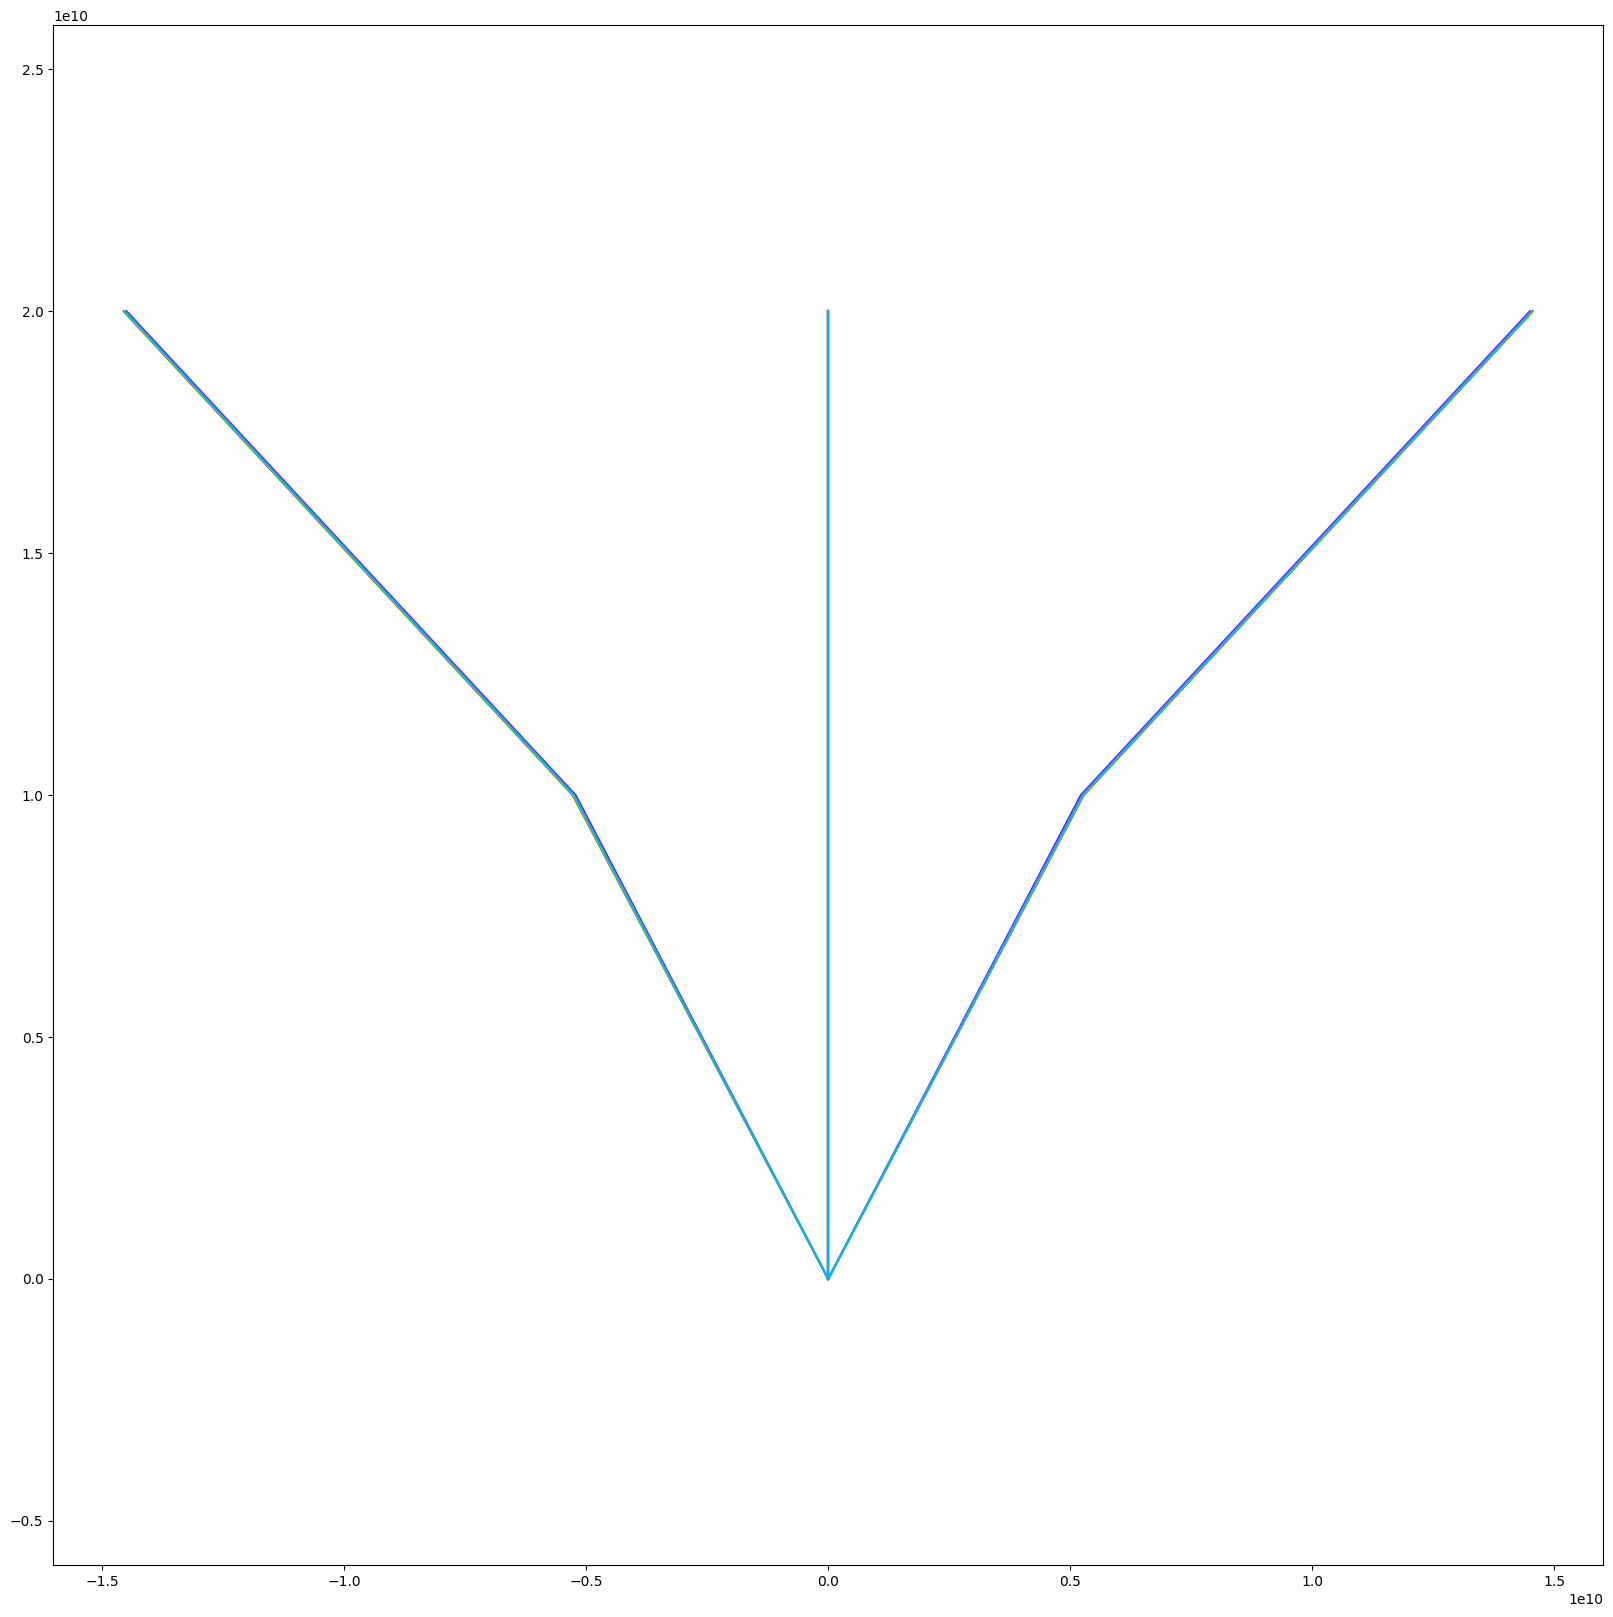

In [12]:
#generate a bunch of point sources on axis at the wavelengths we are interested in
src = pyo.PointSource('light source', pyo.Placement([0, 0, 0], [1, 0, 0]), NA=(1.0/1.47), color=(1,0,0), wavelength=642.)
src4 = pyo.PointSource('light source', pyo.Placement([0, 0, 0], [1, 0, 0]), NA=(1.0/1.47), color=(0,.7,1), wavelength=488.)
src2 = pyo.PointSource('light source', pyo.Placement([0, 0, 0], [1, 0, 0]), NA=(1.0/1.47), color=(.5,0,1), wavelength=405.)
src3 = pyo.PointSource('light source', pyo.Placement([0, 0, 0], [1, 0, 0]), NA=(1.0/1.47), color=(.3,1,0), wavelength=568.)

#generate some off axis sources at the same wavelengths (to test for field-dependant effects)
dx = 240e-3
src_a = pyo.PointSource('light source', pyo.Placement([0,dx, 0], [1, 0, 0]), NA=(1.0/1.47), color=(1,0,0), wavelength=642.)
src4_a = pyo.PointSource('light source', pyo.Placement([0, dx, 0], [1, 0, 0]), NA=(1.0/1.47), color=(0,.7,1), wavelength=488.)
src2_a = pyo.PointSource('light source', pyo.Placement([0, dx, 0], [1, 0, 0]), NA=(1.0/1.47), color=(.5,0,1), wavelength=405.)
src3_a = pyo.PointSource('light source', pyo.Placement([0, dx, 0], [1, 0, 0]), NA=(1.0/1.47), color=(.3,1,0), wavelength=568.)

# generate point sources in the objective design range
src_800 = pyo.PointSource('light source', pyo.Placement([0, 0, 0], [1, 0, 0]), NA=(1.0/1.47), color=(.3,1,0), wavelength=800.)
src_900 = pyo.PointSource('light source', pyo.Placement([0, 0, 0], [1, 0, 0]), NA=(1.0/1.47), color=(.3,1,0), wavelength=900.)
src_1000 = pyo.PointSource('light source', pyo.Placement([0, 0, 0], [1, 0, 0]), NA=(1.0/1.47), color=(.3,1,0), wavelength=1000.)
#src4 = pyo.PointSource('light source', pyo.Placement([0, 0, 0], [1, 0, 0]), NA=(1.0/1.47), color=(0,1,1), wavelength=900.)

#propagate the on-axis sources through the system and visually confirm that it's behaving as expected
figure(figsize=(20,20))
plot_system2d(s, 'xy')
plot2d(s.propagate(src.chief_rays), 'xy')
plot2d(s.propagate(src2.chief_rays), 'xy')
plot2d(s.propagate(src3.chief_rays), 'xy')
plot2d(s.propagate(src4.chief_rays), 'xy')

# optionally, propagate off axis sources as well
# plot2d(s.propagate(src_a.chief_rays), 'xy')
# plot2d(s.propagate(src2_a.chief_rays), 'xy')
# plot2d(s.propagate(src3_a.chief_rays), 'xy')
# plot2d(s.propagate(src4_a.chief_rays), 'xy')
axis('equal')